# Chapter 01

In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import arviz as az

In [2]:
np.random.seed(123)

In [3]:
def post(theta, Y, alpha=1, beta=1):
    if 0 <= theta <= 1:
        prior = stats.beta(alpha, beta).pdf(theta)
        like = stats.bernoulli(theta).pmf(Y).prod()
        prob = like * prior
    else:
        prob = -np.inf
    return prob
    

In [4]:
Y = stats.bernoulli(0.7).rvs(20)

In [5]:
n_iters = 1000
can_sd = 0.05
alpha = beta = 1
theta = 0.5

trace = {'theta': np.zeros(n_iters)}
p2 = post(theta, Y, alpha, beta)

for iter in range(n_iters):
    theta_can = stats.norm(theta, can_sd).rvs(1)
    p1 = post(theta_can, Y, alpha, beta)
    pa = p1 / p2

    if pa > stats.uniform(0, 1).rvs(1):
        theta = theta_can
        p2 = p1
    trace['theta'][iter] = theta

/tmp/ipykernel_3647/185124517.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  trace['theta'][iter] = theta


[]

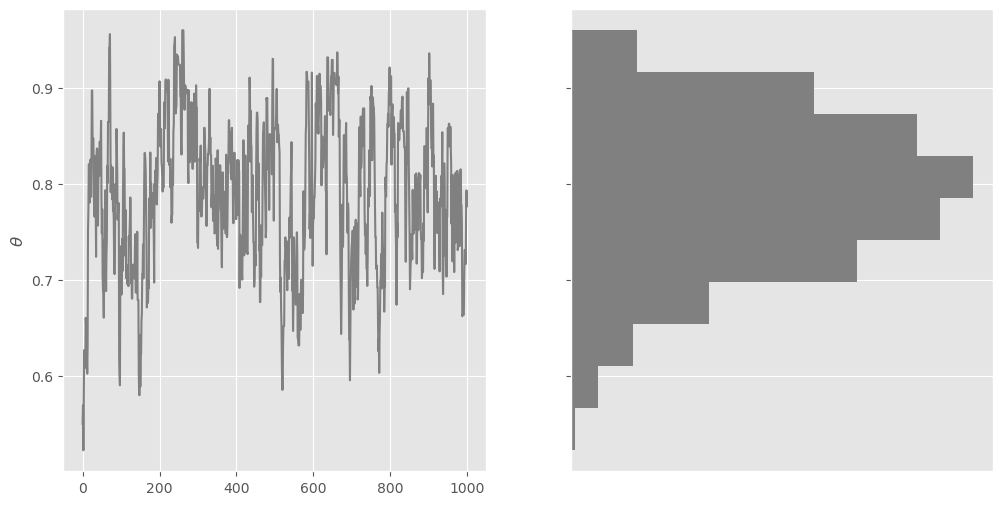

In [6]:
_, axes = plt.subplots(1, 2, sharey=True, figsize=(12, 6))
axes[0].plot(trace['theta'], '0.5')
axes[0].set_ylabel(r'$\theta$')
axes[1].hist(trace['theta'], color='0.5', orientation='horizontal', density=True)
axes[1].set_xticks([])

In [7]:
az.summary(trace, kind='stats', round_to=2)

,mean,sd,hdi_3%,hdi_97%
theta,0.79,0.08,0.66,0.94


<Axes: title={'center': 'theta'}>

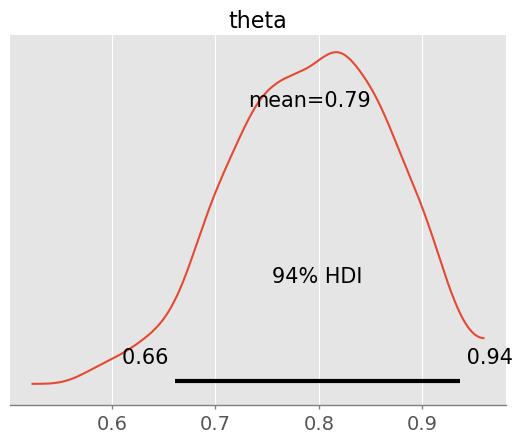

In [8]:
az.plot_posterior(trace)

In [9]:
import pymc as pm
import pytensor as pt

with pm.Model() as model_bjax:
    # specify the prior distribution of unknown parameter
    theta = pm.Beta('theta', alpha=1, beta=1)

    # Specify the likelihood distribution and condition on observed data
    y_obs = pm.Binomial('y_obs', n=1, p=theta, observed=Y)

    # Sample from the posterior distribution
    idata = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [10]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

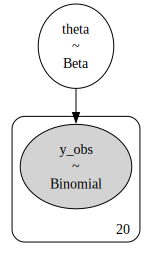

In [11]:
model_bjax.to_graphviz()

In [12]:
idata_prior = pm.sample_prior_predictive(draws=1000, model=model_bjax, random_seed=123, return_inferencedata=True)
idata_full = pm.sample_posterior_predictive(trace=idata, model=model_bjax, extend_inferencedata=True)

Sampling: [theta, y_obs]
Sampling: [y_obs]


Output()

In [13]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

Text(0.5, 0, 'Number of Success')

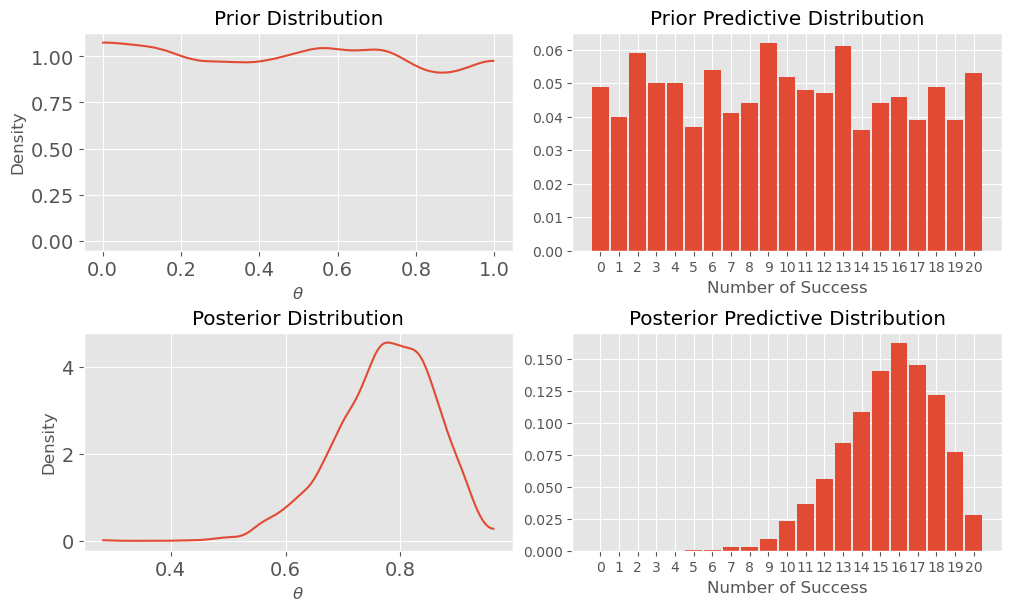

In [14]:
_, ax = plt.subplots(2, 2, figsize=(10, 6), layout='constrained', sharex=False, sharey=False)

ax = np.ravel(ax)

az.plot_dist(idata_prior['prior']['theta'].to_numpy().ravel(), ax=ax[0])
ax[0].set_title('Prior Distribution')
ax[0].set_xlabel(r'$\theta$')
ax[0].set_ylabel('Density')

az.plot_dist(idata_prior['prior_predictive']['y_obs'].sum('y_obs_dim_0').to_numpy().ravel(), 
             ax=ax[1], kind='hist', hist_kwargs={'bins': np.arange(0, 22, 1)})
ax[1].set_title('Prior Predictive Distribution')
ax[1].set_xlabel(r'Number of Success')

az.plot_dist(idata_full['posterior']['theta'].to_numpy().ravel(), ax=ax[2])
ax[2].set_title('Posterior Distribution')
ax[2].set_xlabel(r'$\theta$')
ax[2].set_ylabel('Density')

az.plot_dist(idata_full['posterior_predictive']['y_obs'].sum('y_obs_dim_2').to_numpy().ravel(),
             ax=ax[3], kind='hist', hist_kwargs={'bins': np.arange(0, 22, 1)})
ax[3].set_title('Posterior Predictive Distribution')
ax[3].set_xlabel('Number of Success')


<Axes: title={'center': 'theta'}>

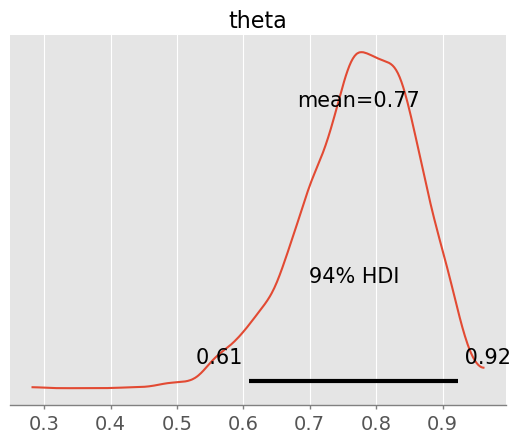

In [15]:
az.plot_posterior(idata_full)

In [16]:
import preliz as pz

In [17]:
theta_mean = idata_full['posterior']['theta'].mean()
print(rf'Mean $\theta$: {theta_mean:.3f}')

posterior_theta_mean = pz.distributions.Binomial(n=len(Y), p=theta_mean).rvs(size=1000, random_state=123)

Mean $\theta$: 0.773


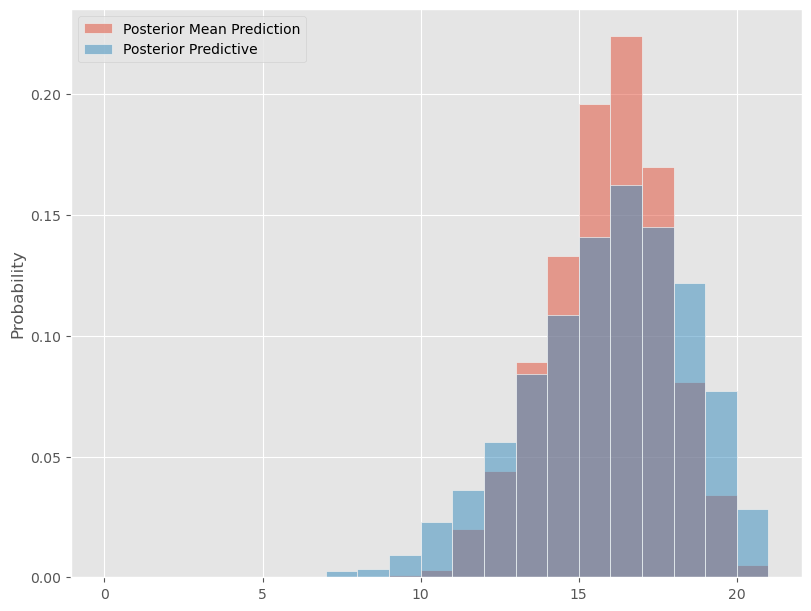

In [18]:
_, ax = plt.subplots(figsize=(8, 6), layout='constrained')

sns.histplot(posterior_theta_mean, bins=np.arange(0, 22, 1), label='Posterior Mean Prediction', ax=ax, alpha=0.5, 
             stat='probability')
sns.histplot(idata_full['posterior_predictive']['y_obs'].sum('y_obs_dim_2').to_numpy().ravel(),
             label='Posterior Predictive', bins=np.arange(0, 22, 1), ax=ax, alpha=0.5, stat='probability')
ax.legend()

In [19]:
import scipy

/tmp/ipykernel_3647/3403053486.py:20: RuntimeWarning: invalid value encountered in divide
  ax[idx].plot(np.divide(y, N), 0, color='k', marker='o', ms=12)


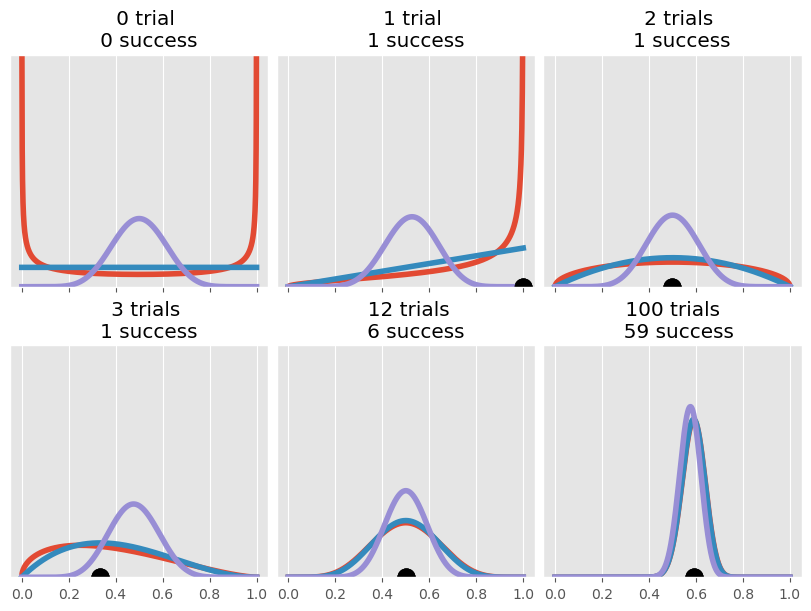

In [20]:
_, ax = plt.subplots(2, 3, sharey=True, sharex=True, layout='constrained', figsize=(8, 6))
ax = np.ravel(ax)

n_trials = [0, 1, 2, 3, 12, 100]
success = [0, 1, 1, 1, 6, 59]
data = zip(n_trials, success)

beta_params = [(0.5, 0.5), (1, 1), (10, 10)]

theta = np.linspace(0, 1, 1500)

for idx, (N, y) in enumerate(data):
    s_n = ("s" if (N > 1) else "")
    for jdx, (a_prior, b_prior) in enumerate(beta_params):
        p_theta_given_y = scipy.stats.beta.pdf(theta, a_prior + y, b_prior + N - y)

        ax[idx].plot(theta, p_theta_given_y, lw=4, color=f'C{jdx}')
        ax[idx].set_yticks([])
        ax[idx].set_ylim(0, 12)
        ax[idx].plot(np.divide(y, N), 0, color='k', marker='o', ms=12)
        ax[idx].set_title(f'{N:4d} trial{s_n} \n{y:4d} success')

In [21]:
from scipy.stats import entropy
from scipy.optimize import minimize

Text(0, 0.5, '$p(t)$')

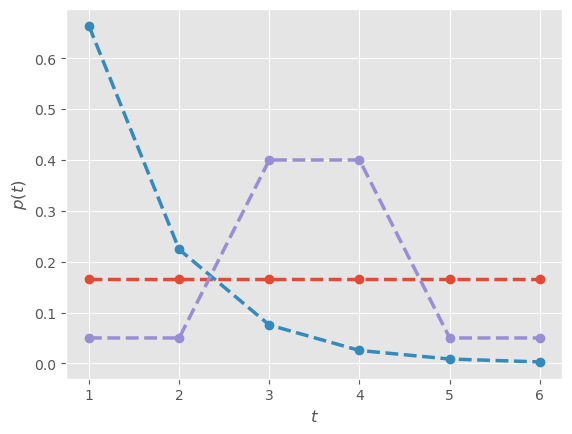

In [22]:
cons = [[{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}],
        [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
         {'type': 'eq', 'fun': lambda x: 1.5 - np.sum(x * np.arange(1, 7))}],
        [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
         {'type': 'eq', 'fun': lambda x: np.sum(x[2:4]) - 0.8}]]


max_ent = []
for i, c in enumerate(cons):
    val = minimize(lambda x: -entropy(x), x0=[1/6]*6, bounds=[(0., 1.0)]*6,
                   constraints=c)['x']
    max_ent.append(entropy(val))
    plt.plot(np.arange(1, 7), val, 'o--', color=f'C{i}', lw=2.5)

plt.xlabel(r'$t$')
plt.ylabel(r'$p(t)$')

In [23]:
ite = 100_000
entropies = np.zeros((3, ite))
for idx in range(ite):
    rnds = np.zeros(6)
    total = 0
    x_ = np.random.choice(np.arange(1, 7), size=6, replace=False)
    for i in x_[:-1]:
        rnd = np.random.uniform(0, 1-total)
        rnds[i-1] = rnd
        total = rnds.sum()
    rnds[-1] = 1 - rnds[:-1].sum()
    H = entropy(rnds)
    entropies[0, idx] = H
    if abs(1.5 - np.sum(rnds * x_)) < 0.01:
        entropies[1, idx] = H
    prob_34 = sum(rnds[np.argwhere((x_ == 3) | (x_ == 4)).ravel()])
    if abs(0.8 - prob_34) < 0.01:
        entropies[2, idx] = H

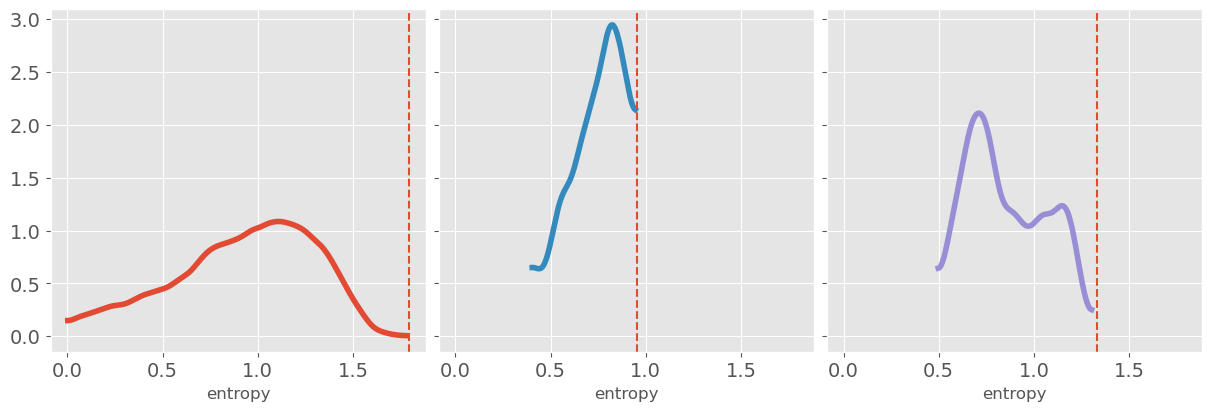

In [24]:
_, ax = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True, layout='constrained')

for i in range(3):
    az.plot_kde(entropies[i][np.nonzero(entropies[i])], ax=ax[i], plot_kwargs={'color':f'C{i}', 'lw':4})
    ax[i].axvline(max_ent[i], 0, 1, ls='--')
    # ax[i].set_yticks([])
    ax[i].set_xlabel('entropy')

Ex. 1H24. Yuo planted 12 seedlings and 3 germinate.  Let us call $\theta$ the probability that a seedling germinates.  Assume $Beta(1,1)$ prior distribution for $\theta$.

1. Use pen and paper to compute the posterior mean and standard deviation. Verify your calculation using scipy.

Solution: $\alpha_{prior} = 1$ and $\beta_{prior} = 1$ and $N=12$ and $y=3$.  Therefore, 

$$\alpha_{posterior} = \alpha_{prior} + y = 4$$
$$\beta_{posterior} = \beta_{prior} + N - y = 10$$
$$E[\theta_{posterior}] = \frac{\alpha_{posterior}}{\alpha_{posterior} + \beta_{posterior}} = \frac{4}{4+10} = 0.286$$
$$Var[\theta_{posterior}] = \frac{\alpha_{posterior} \beta_{posterior}}{(\alpha_{posterior} + \beta_{posterior})^2(\alpha_{posterior} + \beta_{posterior} + 1)} = \frac{4\cdot 10}{(4+10)^2(4+10+1)} = 0.0136$$
$$STD[\theta_{posterior}] = 0.1166$$

In [25]:
Y = np.array([1.0]*3 + [0.0]*9)
Y

array([1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [26]:
n_iters = 10_000
can_sd = 0.05
alpha = beta = 1
theta = 0.5

trace = {'theta': np.zeros(n_iters)}
p2 = post(theta, Y, alpha, beta)

for iter in range(n_iters):
    theta_can = stats.norm(theta, can_sd).rvs(1)
    p1 = post(theta_can, Y, alpha, beta)
    pa = p1 / p2

    if pa > stats.uniform(0, 1).rvs(1):
        theta = theta_can
        p2 = p1
    trace['theta'][iter] = theta

/tmp/ipykernel_3647/2921812819.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  trace['theta'][iter] = theta


In [27]:
print(rf'Sampled mean(\theta) = {trace["theta"].mean():.3f}')
print(rf'Sampled stdev(\theta) = {trace["theta"].std(): .3f}')

Sampled mean(\theta) = 0.278
Sampled stdev(\theta) =  0.117


2. Use Scipy to compute the equal-tailed and highest density 94% posterior intervals.

Solution: 94% HDI can be computed as below.

In [28]:
theta_ecdf = scipy.stats.ecdf(trace['theta'])
theta_03 = theta_ecdf.cdf.quantiles[np.argmax(theta_ecdf.cdf.probabilities - 0.03 > 0)]
theta_97 = theta_ecdf.cdf.quantiles[np.argmin(theta_ecdf.cdf.probabilities - 0.97 < 0)]
print(f'94% HDI: ({theta_03:.3f}, {theta_97:0.3f})')

94% HDI: (0.095, 0.532)


3. Use Scipy to compute the posterior predictive probability that at least one seedling will germinate if you plant another 12 seedlings.

Solution:

In [29]:
draws = len(trace['theta']) // 12
print(f'draws = {draws}')

trace2 = trace['theta'][:draws*12].reshape(-1, 12)
print(f'trace2.shape = {trace2.shape}')

print(f'Probability of at least one seedling will germinate if you plant another 12 seedlings: {(trace2.sum(axis=1) >= 1).sum() / trace2.shape[0]:.4f}')

draws = 833
trace2.shape = (833, 12)
Probability of at least one seedling will germinate if you plant another 12 seedlings: 0.9952


4. After obtaining your results with Scipy, repeat this exercise using PyMC and Arviz

Solution: Let's build the model in PyMC

In [30]:
Y.sum()

3.0

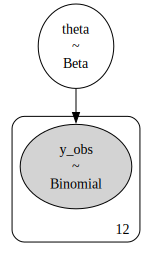

In [38]:
with pm.Model() as model_s:
    # prior
    theta = pm.Beta('theta', alpha=1, beta=1)
    # likelihood
    y_obs = pm.Binomial('y_obs', n=1, p=theta, observed=Y)

model_s.to_graphviz()

Let's investigate prior distribution and prior predictive distribtion.

Sampling: [theta, y_obs]


<Axes: >

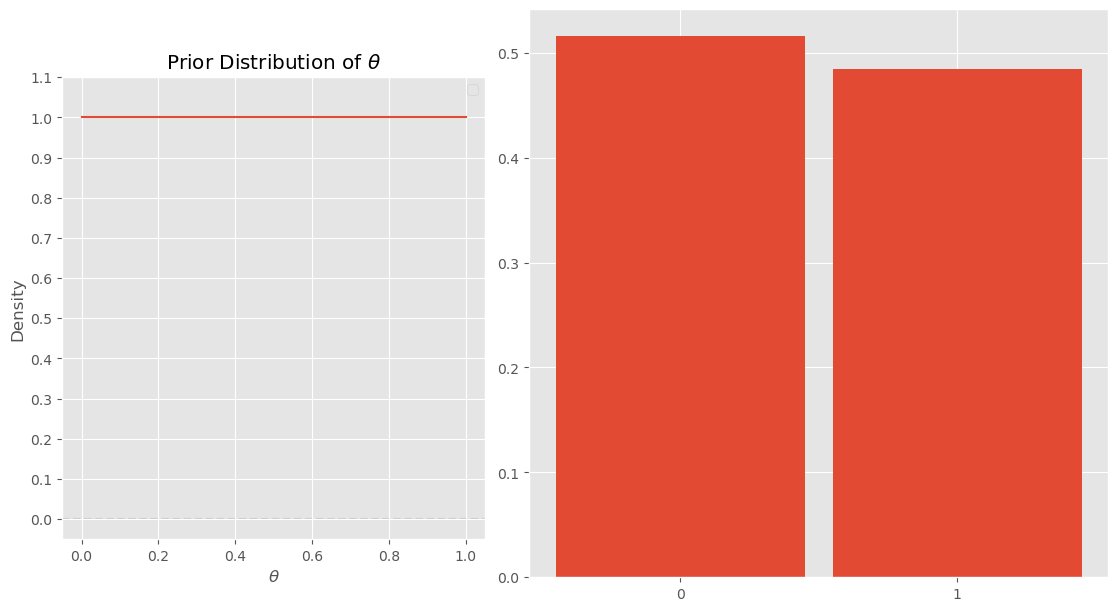

In [39]:
_, ax = plt.subplots(1, 2, figsize=(12, 6), layout='constrained')
ax = np.ravel(ax)

pz.Beta(1, 1).plot_pdf(ax=ax[0])
ax[0].legend([])
ax[0].set_xlabel(r'$\theta$')
ax[0].set_ylabel('Density')
ax[0].set_title(r'Prior Distribution of $\theta$')
_ = ax[0].set_yticks(np.arange(0, 1.2, 0.1))

prior_predictive = pm.sample_prior_predictive(draws=1000, model=model_s, random_seed=123)
az.plot_dist(prior_predictive['prior_predictive']['y_obs'].to_numpy().ravel(),
             kind='hist', ax=ax[1])

It seems that both the prior and prior predictive distribtions look reasonable. Now, let's move onto the posterior distribution.

In [57]:
with model_s:
    idata_post = pm.sample(nuts_sampler='blackjax')
    # idata_post = pm.sample()

Running window adaptation


array([[<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>]], dtype=object)

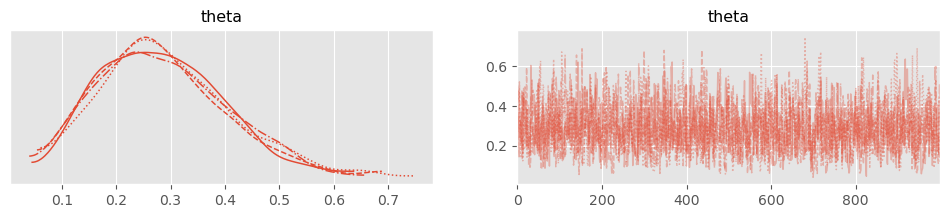

In [61]:
az.plot_trace(idata_post)

<Axes: title={'center': 'theta'}>

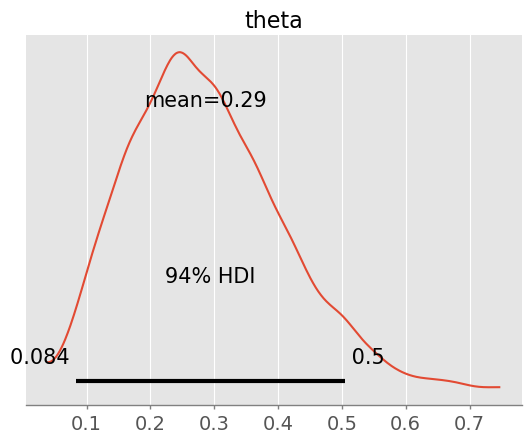

In [58]:
az.plot_posterior(idata_post)

In [59]:
idata_post = pm.sample_posterior_predictive(idata_post, model=model_s, var_names=['y_obs'],
                                            random_seed=123, extend_inferencedata=True)

Sampling: [y_obs]


Output()

Text(0.5, 1.0, 'Posterior Predictive Distribution')

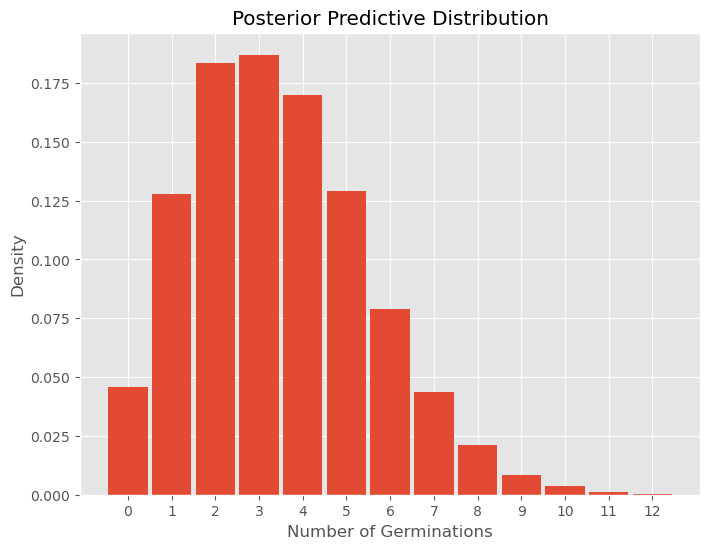

In [78]:
_, ax = plt.subplots(figsize=(8, 6))

az.plot_dist(idata_post['posterior_predictive']['y_obs'].sum('y_obs_dim_2').to_numpy().ravel(),
             kind='hist',
             ax=ax)
ax.set_xlabel('Number of Germinations')
ax.set_ylabel('Density')
ax.set_title('Posterior Predictive Distribution')